In [3]:
from AssignmentQ2_Group5_D import * # Restart kernel if file changed
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
from IPython.display import clear_output
clear_output(wait=True)
print("Selected case:", inp)
print('Success, obj:', model.ObjVal) if sol else print('Failed')

Selected case: 5
Success, obj: 320.7038410439465


In [4]:
tol = 1e-6

# Extract solution
solution = []
for v in V:
    print(f"Vehicle {v}:", end=' ')
    route = []
    i = 0
    while True:
        js = [j for j in N if abs(x[i, j, v].X - 1) <= tol]
        assert len(js) <= 1
        if not js: break
        j = int(*js)
        route.append((i, j))
        if j == 0: break
        i = j
    print(', '.join(f"{a:>2} -> {b:<2}" for a, b in route))
    solution.append(route)

Vehicle 0:  0 -> 3 ,  3 -> 2 ,  2 -> 1 ,  1 -> 7 ,  7 -> 4 ,  4 -> 0 
Vehicle 1:  0 -> 5 ,  5 -> 14, 14 -> 15, 15 -> 17, 17 -> 13, 13 -> 9 ,  9 -> 11, 11 -> 10, 10 -> 8 ,  8 -> 0 
Vehicle 2: 
Vehicle 3:  0 -> 20, 20 -> 6 ,  6 -> 18, 18 -> 19, 19 -> 16, 16 -> 12, 12 -> 0 


In [ ]:
import pandas as pd
pd.options.display.width = 250
pd.options.display.precision = 2
for v, route in enumerate(solution):
    if not route: continue
    data = []
    load = 0
    for i, j in route:
        load += q[i]
        data.append({
            'node': f"{i}->{j}",
            'arr_time': tau_a[i, v].X,
            'dep_time': tau_d[i, v].X,
            'travel_time': d[i][j] * s,
            'arr_charge': beta_a[i, v].X,
            'dep_charge': beta_d[i, v].X,
            'charged': sum(beta_q[i, p, v].X for p in P),
            'has_charger': bs[i],
            'stay_time': tau_d[i, v].X - tau_a[i, v].X,
            'charging_time': ", ".join([f"{p}: {tau_ce[i, p, v].X - tau_cs[i, p, v].X:.2f}"
                for p in P if abs(beta_c[i, p, v].X) <= tol]),
            'service_time': ts[i],
            'load': load,
        })
    df = pd.DataFrame(data)
    print('vehicle:', v)
    print(df)
    print('\n')

vehicle: 0
   node  arr_time  dep_time  travel_time  arr_charge  dep_charge  charged  has_charger  stay_time charging_time  service_time  load
0  0->3      0.00      0.00        58.14      140.00      140.00      0.0            0       0.00                           0     0
1  3->2     58.14    157.00        34.06       99.30       99.30      0.0            0      98.86                          90    10
2  2->1    191.06    303.00        17.20       75.46       75.46      0.0            0     111.94                          90    40
3  1->7    320.20    410.20        15.62       63.42       63.42      0.0            1      90.00                          90    50
4  7->4    425.83   1163.00         8.94       52.48       52.48      0.0            0     737.17                          90    70
5  4->0   1171.94   1261.94        51.22       46.22       46.22      0.0            1      90.00                          90    80


vehicle: 1
     node  arr_time  dep_time  travel_time  arr_char

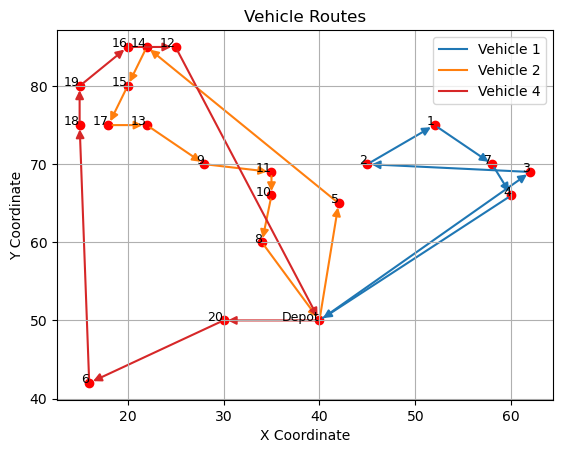

In [ ]:
# Plotting points
x_coords = []
y_coords = []
for n in node_data:
    x_coords.append(n.XCOORD)
    y_coords.append(n.YCOORD)
plt.scatter(x_coords, y_coords, color='red')
plt.text(node_data[0].XCOORD, node_data[0].YCOORD, 'Depot', fontsize=9, ha='right')
for i, n in enumerate(node_data[1:], start=1):
    plt.text(n.XCOORD, n.YCOORD, f'{i}', fontsize=9, ha='right')

# Plotting the routes put arrows between the nodes
cmap = plt.get_cmap('tab10')
for v, route in enumerate(solution):
    if not route: 
        continue
    
    color = cmap(v % 10)
    plt.plot([], [], color=color, label=f'Vehicle {v+1}')
    ax = plt.gca()

    for i, j in route:
        x1, y1 = node_data[i].XCOORD, node_data[i].YCOORD
        x2, y2 = node_data[j].XCOORD, node_data[j].YCOORD

        if x1 == x2 and y1 == y2:
            continue

        arr = FancyArrowPatch(
            (x1, y1), (x2, y2),
            arrowstyle='-|>', mutation_scale=12,
            color=color, linewidth=1.5,
            shrinkA=3, shrinkB=3)
        ax.add_patch(arr)

plt.title('Vehicle Routes')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend()
plt.grid()
plt.show()